<a href="https://colab.research.google.com/github/BDonadelli/Codigos-em-financas/blob/main/Bollinger.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


ESTRATÉGIA
1. fechou fora-fechou dentro com o ultimo fechamento 3 tr da sma20, entra no rompimento de máxima / mínima do ultimo dia
2. stop no fundo/topo do ff-fd, saída se chegar na media 20 dos fechamentos



In [1]:
import pandas as pd
import numpy as np
import copy
import datetime
import yfinance as yf
import os

In [2]:
def reset_data() :
  data=pd.read_csv(os.getcwd()+'/data/data.csv')
  data.set_index(data['Date'],inplace=True)
  data.drop(columns=['Date'],axis=1,inplace=True)
 

In [3]:
codigo = str(input('codigo ='))
periodo='max'

In [4]:
data = pd.DataFrame()
data = yf.download(tickers=codigo+'.SA' , period=periodo , progress = False  , auto_adjust=True)

In [5]:
import talib 

data['u_bb'], data['bb_m'], data['l_bb'] = talib.BBANDS(data['Close'], timeperiod = 20)
data['atr'] = talib.ATR(high=data['High'],close=data['Close'],low=data['Low'], timeperiod=20)

In [6]:
data

Open       High        Low      Close    Volume       u_bb  \
Date                                                                          
2000-01-03   1.096621   1.117509   1.070511   1.070511    514800        NaN   
2000-01-04   1.070511   1.073122   1.019597   1.019597    314100        NaN   
2000-01-05   1.018291   1.031346   0.981737   1.030041    478800        NaN   
2000-01-06   1.030040   1.044401   1.018291   1.044401    205200        NaN   
2000-01-07   1.044401   1.044401   1.020902   1.020902    394200        NaN   
...               ...        ...        ...        ...       ...        ...   
2024-02-21  59.096274  59.365256  58.837256  59.215820  22916100  59.847858   
2024-02-22  58.689999  58.759998  57.919998  58.099998   9899200  59.859873   
2024-02-23  58.130001  58.259998  57.139999  57.380001  10278100  59.831169   
2024-02-26  57.410000  58.189999  57.250000  57.930000   6720900  59.805655   
2024-02-27  58.189999  58.750000  58.000000  58.580002   4668400  59.853371   

                 bb_m       l_bb       atr  
Date                                        
2000-01-03        NaN        NaN       NaN  
2000-01-04        NaN        NaN       NaN  
2000-01-05        NaN        NaN       NaN  
2000-01-06        NaN        NaN       NaN  
2000-01-07        NaN        NaN       NaN  
...               ...        ...       ...  
2024-02-21  57.638295  55.428732  1.037644  
2024-02-22  57.726957  55.594040  1.050553  
2024-02-23  57.774139  55.717110  1.054025  
2024-02-26  57.852309  55.898963  1.048324  
2024-02-27  57.943552  56.033733  1.036908  

[6065 rows x 9 columns]

In [7]:
data.dropna(inplace=True)
data.to_csv(os.getcwd()+'/data/data.csv')

### entrada

In [8]:
desvio = 2.95 # atrs

# Compra
signalB = np.where((data['Close'].shift(2) < data['l_bb'].shift(2))        #anteontem fechou fora
                  & (data['Close'].shift(1) > data['l_bb'].shift(1))       #ontem fechou dentro
                  & (np.abs(data['Close'] - data['bb_m']) > desvio*data['atr']) # e fechou longe da média
                  & (data['Close'] >= np.maximum(data['Close'].shift(1),data['Close'].shift(2)) ) # hoje rompeu as maximas
                  , 1, 0)
# Venda descoberta
signalS = np.where((data['Close'].shift(2) > data['u_bb'].shift(2))          #anteontem fechou fora
                  & (data['Close'].shift(1) < data['u_bb'].shift(1))         #ontem fechou dentro
                  & (np.abs(data['Close'] - data['bb_m']) > desvio*data['atr'])   # e fechou longe da média
                  & (data['Close'] <= np.minimum(data['Close'].shift(1),data['Close'].shift(2)) ) # hoje rompeu as minimas
                  , -1, 0)
data['signal'] = signalB + signalS

In [9]:
aux = data[(data['signal']== 1) | (data['signal']== -1)].copy()

### saída

In [10]:
m=len(data)

i=0
while (i < m -1) :
    while (i < m -1 and data['signal'].iloc[i] == 0) : i+=1
    j=i
    if data['signal'].iloc[j] == 1 :
        while (j < m-1 and data['Close'].iloc[j] < data['bb_m'].iloc[j]  ) : j+=1
    else:
        while (j < m-1 and data['Close'].iloc[j] > data['bb_m'].iloc[j]  ) : j+=1
    # data.iloc[i:j,'signal'] = data['signal'].iloc[i]
    data.loc[data.index[i]:data.index[j],'signal'] = data['signal'].iloc[i]

    i=j+1



In [11]:
data

Open       High        Low      Close    Volume       u_bb  \
Date                                                                          
2000-01-31   1.037874   1.037874   1.018291   1.031346    286200   1.102444   
2000-02-01   1.033957   1.033957   1.020902   1.031346    277200   1.101186   
2000-02-02   1.031346   1.031346   1.018291   1.020902     76500   1.102174   
2000-02-03   1.044401   1.044401   1.020902   1.031346    138600   1.102752   
2000-02-04   1.044401   1.063983   1.026124   1.044401    254700   1.101072   
...               ...        ...        ...        ...       ...        ...   
2024-02-21  59.096274  59.365256  58.837256  59.215820  22916100  59.847858   
2024-02-22  58.689999  58.759998  57.919998  58.099998   9899200  59.859873   
2024-02-23  58.130001  58.259998  57.139999  57.380001  10278100  59.831169   
2024-02-26  57.410000  58.189999  57.250000  57.930000   6720900  59.805655   
2024-02-27  58.189999  58.750000  58.000000  58.580002   4668400  59.853371   

                 bb_m       l_bb       atr  signal  
Date                                                
2000-01-31   1.058761   1.015079  0.040666       0  
2000-02-01   1.059349   1.017512  0.039286       0  
2000-02-02   1.058892   1.015610  0.037974       0  
2000-02-03   1.058239   1.013726  0.037251       0  
2000-02-04   1.059414   1.017757  0.037281       0  
...               ...        ...       ...     ...  
2024-02-21  57.638295  55.428732  1.037644       0  
2024-02-22  57.726957  55.594040  1.050553       0  
2024-02-23  57.774139  55.717110  1.054025       0  
2024-02-26  57.852309  55.898963  1.048324       0  
2024-02-27  57.943552  56.033733  1.036908       0  

[6045 rows x 10 columns]

In [12]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(rows=3, cols=1) #go.Figure()
fig.add_trace(go.Scatter(x = data.index , y = data['Close'].values , name="preço"),1,1)
fig.add_trace(go.Scatter(x = data.index , y = data['u_bb'].values, mode='lines', 
                         line=dict(color='firebrick', width=2, dash='dash'), name="mms20"),1,1)
fig.add_trace(go.Scatter(x = data.index , y = data['l_bb'].values, mode='lines', 
                         line=dict(color='gray', width=2, dash='dash'), name="upper bb"),1,1)
fig.add_trace(go.Scatter(x = data.index , y = data['bb_m'].values, mode='lines', 
                         line=dict(color='gray', width=2, dash='dash'), name="lower bb"),1,1)
fig.add_trace(go.Scatter(x = aux.index, y = data['Close'] , mode='markers' ,name='sinal',
                             marker=dict(size=12, symbol="arrow", angle=45, line=dict(width=2, color="DarkSlateGrey"))
                         ),1,1)
fig.update_traces(
    marker=dict(size=12, symbol="arrow", angle=45, line=dict(width=2, color="DarkSlateGrey")),
    selector=dict(mode="markers"),
)
# fig.add_trace(go.Scatter(x = df.loc[sai].index, y = df.loc[sai]['Close '+ativo] , mode='markers' ,name='Saida',
#                          marker=dict(size=12, symbol="arrow", angle=-135, line=dict(width=2, color="red"))
#                          ),1,1)
fig.add_trace(go.Scatter(x = data.index , y = data['signal'].values , name="sinal"),2,1)


fig.add_trace(go.Scatter(x =data.index , y = data['atr'].values*desvio , mode='lines', name=f"{desvio}*ATR"),3,1)


fig.show()

In [13]:
data['retrn'] =  np.log(data['Close']) - np.log(data['Close'].shift(1))
data['strategy_returns'] = data['retrn'] * (data['signal'].shift(1))

In [14]:
print(f"Strategy returns: {data['strategy_returns'].cumsum().iloc[-1]}")


Strategy returns: -0.4822509259594596


In [15]:
print("Buy and hold returns:",data['retrn'].cumsum().iloc[-1])


Buy and hold returns: 4.039528547239534


In [16]:
df = data.copy()
df["Date"]=df.index

# feriados

inicio = df.index[0].strftime("%Y-%m-%d")
fim = df.index[-1].strftime("%Y-%m-%d")

url = 'https://raw.githubusercontent.com/BDonadelli/Codigos-em-financas/main/data/feriados.csv'

feriado = pd.read_csv(url)
feriado['Data'] =  pd.to_datetime(feriado['Data'], format='%d/%m/%Y')
feriado.set_index(feriado.Data, inplace=True)
feriado['Data'] = feriado['Data'].astype(str)
lista = feriado.Data.loc[inicio:fim].values

# feriados

# import plotly.io as pio
# pio.renderers.default = 'vscode'


fig = make_subplots(rows=3, cols=1,
                          #shared_xaxes=True,
                          vertical_spacing=0.05,
                          subplot_titles=(codigo, 'sinal C/V', 'ATR'),
                          row_width=[0.1, 0.2, 0.4])

fig.append_trace({ 'x': df.Date,
           'open': df.Open,
           'close': df.Close,
           'high': df.High,
           'low': df.Low,
           'type': 'candlestick',
           'name': codigo,
           'showlegend': True }
, row=1, col=1 )

fig.append_trace(go.Scatter( name="sma20",
                 line=dict(color='lightblue'),
    x=df.index,
    y=df.bb_m,
), row=1, col=1)

fig.append_trace(go.Scatter( name="sma20 + 2dp",
                 line=dict(color='lightgreen'),
    x=df.index,
    y=df.u_bb,
), row=1, col=1 )

fig.append_trace(go.Scatter( name="sma20 - 2dp",
                 line=dict(color='lightgreen'),
    x=df.index,
    y=df.l_bb,
), row=1, col=1)

fig.append_trace(go.Scatter(x = data.index , y = data['signal'].values , name="sinal"),2,1)
fig.update_traces(
    marker=dict(size=12, symbol="arrow", angle=45, line=dict(width=2, color="DarkSlateGrey")),
    selector=dict(mode="markers"),)

fig.append_trace(go.Scatter( name="sinal C/V",
    x = df.Date,
    y = df.atr,
), row=3, col=1)

fig.append_trace(go.Scatter( name="sinal C/V",
    x = df.Date,
    y = df.signal,
), row=2, col=1)

fig.update_xaxes(
        rangeslider_visible=False,
        rangebreaks=[
            # {'pattern':'day of week' , 'bounds':[6,1] , 'pattern':'hour' , 'bound':[18,10]},
            # NOTE: Below values are bound (not single values), ie. hide x to y
            #dict(bounds=["sat", "mon"]),  # hide weekends, eg. hide sat to before mon
            #dict(bounds=[16, 9.5], pattern="hour"),  # hide hours outside of 9.30am-4pm
            dict(values=lista)#["2018-12-24","2019-12-24", "2020-12-24", "2021-12-24", "2022-12-24"]) ,
            #dict(values=["2018-12-25","2019-12-25", "2020-12-25", "2021-12-24", "2022-12-24"]) ,
            #dict(values=["2018-01-01","2019-01-01", "2020-01-01", "2021-01-01", "2022-01-01"])
        ]
    )

fig.update_layout(height=900, width=1200)

fig.show()


<Axes: xlabel='Date'>

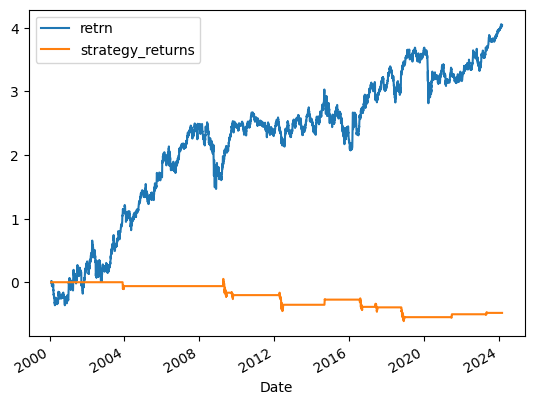

In [17]:
data[['retrn','strategy_returns']].cumsum().plot()


In [18]:
import quantstats as qs

help(qs.reports.full)

Help on function full in module quantstats.reports:

full(returns, benchmark=None, rf=0.0, grayscale=False, figsize=(8, 5), display=True, compounded=True, periods_per_year=252, match_dates=True, **kwargs)



                           Strategy
-------------------------  ----------
Start Period               2000-02-01
End Period                 2024-02-27
Risk-Free Rate             0.0%
Time in Market             5.0%

Cumulative Return          -42.39%
CAGR﹪                     -1.57%

Sharpe                     -0.27
Prob. Sharpe Ratio         9.63%
Smart Sharpe               -0.26
Sortino                    -0.35
Smart Sortino              -0.35
Sortino/√2                 -0.25
Smart Sortino/√2           -0.24
Omega                      0.81

Max Drawdown               -51.51%
Longest DD Days            5434
Volatility (ann.)          7.59%
Calmar                     -0.03
Skew                       -0.76
Kurtosis                   80.84

Expected Daily %           -0.01%
Expected Monthly %         -0.19%
Expected Yearly %          -2.18%
Kelly Criterion            -11.27%
Risk of Ruin               0.0%
Daily Value-at-Risk        -0.79%
Expected Shortfall (cVaR)  -0.79%

Max Consecutiv

None

Start      Valley         End  Days  Max Drawdown  99% Max Drawdown
1  2009-04-13  2018-11-28  2024-02-27  5434    -51.512347        -48.285723
2  2003-11-26  2003-12-17  2009-04-07  1960    -10.593747         -7.394269

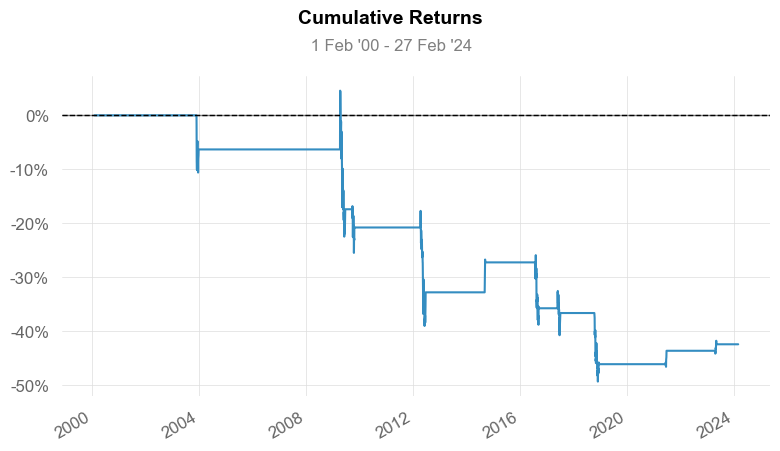

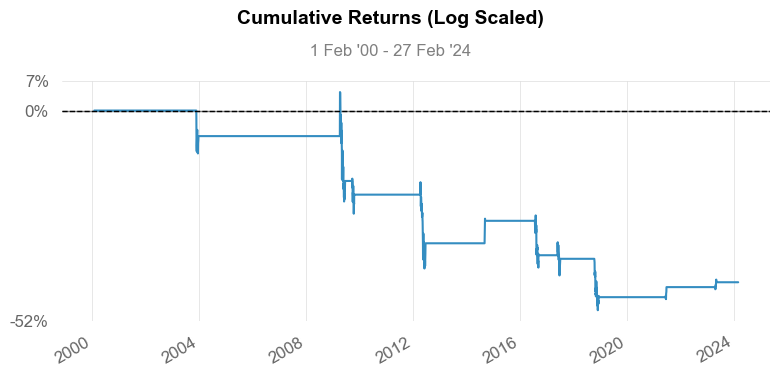

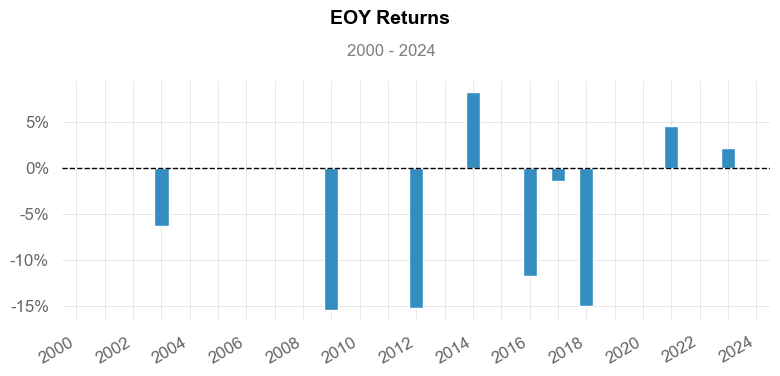

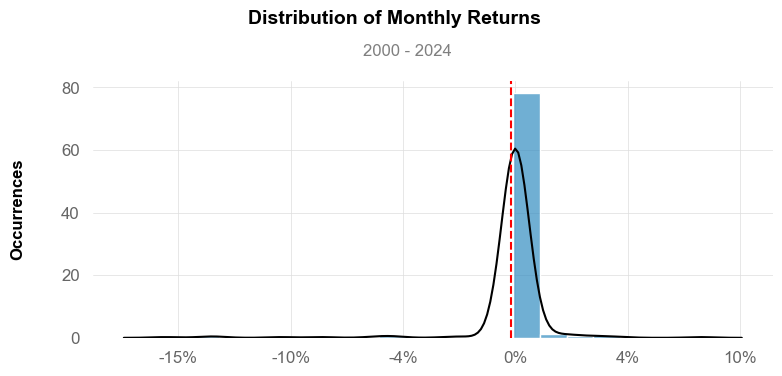

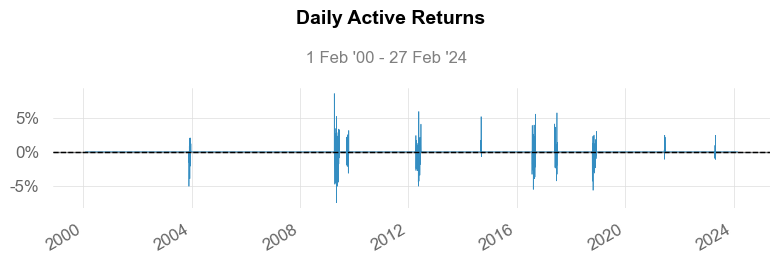

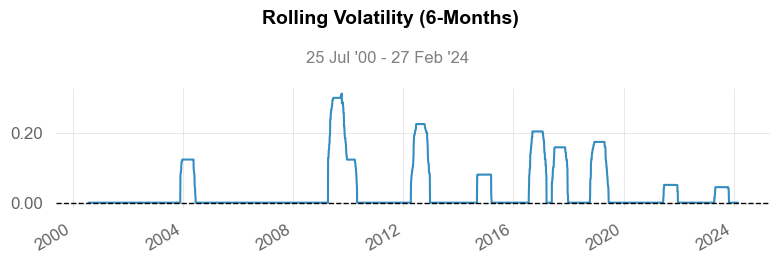

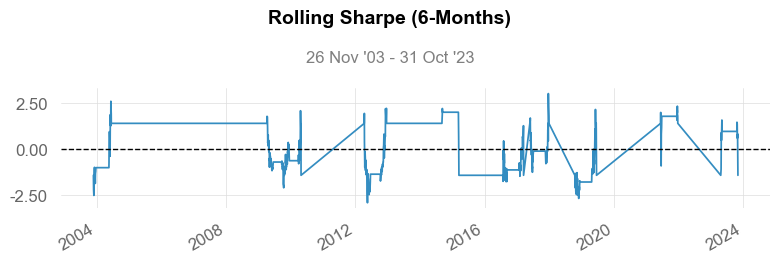

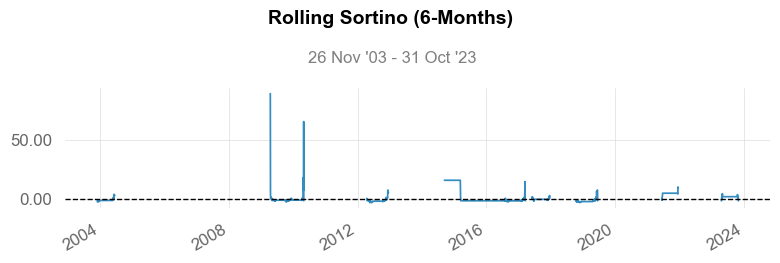

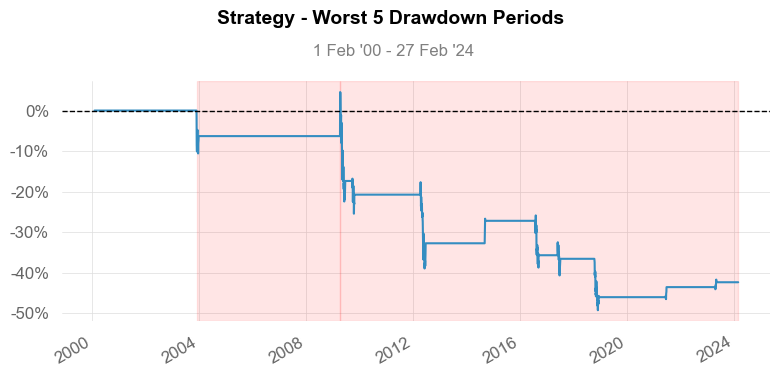

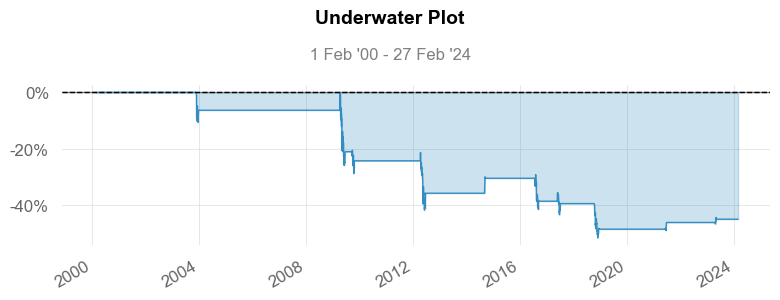

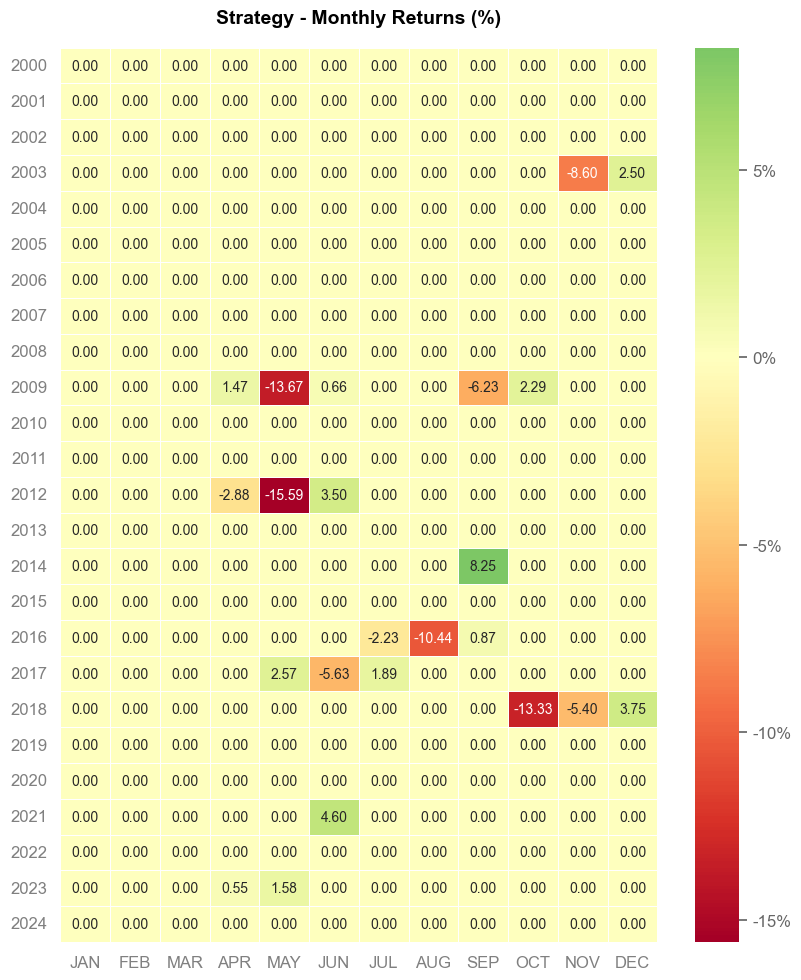

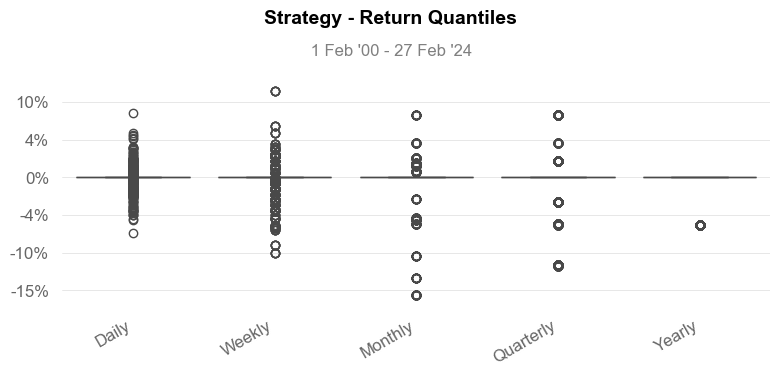

In [19]:
import warnings
# Suppress FutureWarning messages
warnings.simplefilter(action='ignore', category=FutureWarning)

qs.reports.full(data['strategy_returns'])

In [20]:
data[['retrn','strategy_returns']]

retrn  strategy_returns
Date                                  
2000-01-31       NaN               NaN
2000-02-01  0.000000               0.0
2000-02-02 -0.010178              -0.0
2000-02-03  0.010178               0.0
2000-02-04  0.012578               0.0
...              ...               ...
2024-02-21  0.002358               0.0
2024-02-22 -0.019023              -0.0
2024-02-23 -0.012470              -0.0
2024-02-26  0.009540               0.0
2024-02-27  0.011158               0.0

[6045 rows x 2 columns]